In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Generate the data for the hinge experiment

In [2]:
from decision_learning.benchmarks.hinge.data import genData
from decision_learning.benchmarks.hinge.oracle import opt_oracle

data = genData(num_data=200, m=0, alpha=1, seed=885309)

# # Example usage
feat = data["feat"]         # shape (100, 1)
cond_exp_cost = data["cond_exp_cost"]
epsilon = data["epsilon"]
cost = torch.tensor(data["cost"], dtype=torch.float32)

data.keys()

dict_keys(['feat', 'cond_exp_cost', 'cost', 'epsilon', 'x'])

array([-1.98147299])

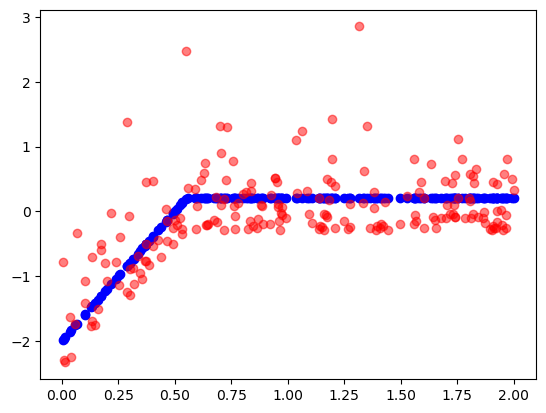

In [3]:
#plot feat vs. cost_true
#overlay data points for feature vs. cost
plt.scatter(feat, cond_exp_cost, label="True Cost", color="blue")
plt.scatter(feat, cost, label="Noisy Cost", color="red", alpha=0.5)

min(sorted(cond_exp_cost))

## Set up the various losses

In [4]:
from functools import partial
from decision_learning.modeling.loss import PGLoss, MSELoss, SPOPlusLoss, FYLoss, CILOLoss
from decision_learning.utils import handle_solver
from decision_learning.modeling.smoothing import RandomizedSmoothingWrapper

# data from previous cell
X = torch.tensor(data["feat"], dtype=torch.float32)         # (n, 1)
cond_exp_cost = torch.tensor(data["cond_exp_cost"], dtype=torch.float32)


# oracle wrapper (batched)
optmodel = partial(
    handle_solver,
    optmodel=opt_oracle,
    detach_tensor=False,
    solver_batch_solve=True,
)

# true objective under true costs (for decision regret)
full_info_sol, full_info_obj = optmodel(cond_exp_cost)
obs_sol, obs_obj = optmodel(cost)

In [5]:
#pass with either the observe cost or teh cond_exp cost
def decision_loss(pred_cost, cost):
      pred_sol, _ = optmodel(pred_cost)

      # Convert solver output to same "array family" as cost
      if isinstance(cost, torch.Tensor):
          pred_sol = torch.as_tensor(pred_sol, dtype=cost.dtype, device=cost.device)
          cost = torch.as_tensor(cost, dtype=cost.dtype, device=cost.device)
      else:
          cost = np.asarray(cost)
          pred_sol = np.asarray(pred_sol, dtype=cost.dtype)

      # Ensure shape (n, 1)
      if pred_sol.ndim == 1:
          pred_sol = pred_sol.reshape(-1, 1)
      if cost.ndim == 1:
          cost = cost.reshape(-1, 1)

      # Per-sample decision loss, shape (n, 1)
      if isinstance(cost, torch.Tensor):
          return (pred_sol * cost).sum(dim=1, keepdim=True)
      return (pred_sol * cost).sum(axis=1, keepdims=True)


# PG loss (backward diff)
PG_STEP_SIZE = 0.2
pgb_loss_fn = PGLoss(optmodel=optmodel, h=PG_STEP_SIZE, finite_diff_type="B")

#PG Loss central finite difference
pgc_loss_fn = PGLoss(optmodel=optmodel, h=PG_STEP_SIZE, finite_diff_type="C")

#MSE Loss
mse_loss_fn = MSELoss()

#SPO+  
spoplus_loss_fn = SPOPlusLoss(optmodel=optmodel)

#unsmoothed FY
fy_loss_fn = FYLoss(optmodel=optmodel)

#CILO Loss
ciloloss_fn = CILOLoss(optmodel=optmodel, beta=obs_obj.mean().item() * .9) # set beta to 90% of the mean observed objective value

In [6]:
#####
# Smoothed Variants

# global smoothing params
SMOOTH_SIGMA = 0.1
SMOOTH_S = 5
SMOOTH_ANTITHETIC = True
SMOOTH_CONTROL_VARIATE = False

def smooth(loss_fn):
      return RandomizedSmoothingWrapper(
        base_loss=loss_fn,
        sigma=SMOOTH_SIGMA,
        s=SMOOTH_S,
        seed=42,
        antithetic=SMOOTH_ANTITHETIC,
        control_variate=SMOOTH_CONTROL_VARIATE,
        reduction="mean",
    )

pgb_smooth = smooth(pgb_loss_fn)
pgc_smooth = smooth(pgc_loss_fn)
spoplus_smooth = smooth(spoplus_loss_fn)
fy_smooth = smooth(fy_loss_fn)

## Evaluate candidate policies across a grid

In [7]:
#betas = np.linspace(-.1, .25, 101)
betas = np.linspace(0, 10, 101)
decision_losses = []
decision_loss_oracle = []
pgb_losses = []
pgc_losses = []
mse_losses = []
spoplus_losses = []
fy_losses = []
cilo_losses =[]


smooth_pgb_losses = []
smooth_pgc_losses = []
smooth_spoplus_losses = []
smooth_fy_losses = []

for beta0 in betas:
    pred_cost = beta0 * X + -2
    
    
    # in-sample decision loss (normalized regret)
    dloss = decision_loss(pred_cost, cost)
    decision_losses.append(dloss.mean().item())
    dloss = decision_loss(pred_cost, cond_exp_cost)
    decision_loss_oracle.append(dloss.mean().item())

    # PG loss (backward diff)
    loss_val = pgb_loss_fn(pred_cost, obs_cost=cost).item()
    pgb_losses.append(loss_val)

    # PG loss (central finite diff)
    loss_val = pgc_loss_fn(pred_cost, obs_cost=cost).item()
    pgc_losses.append(loss_val)

    # MSE loss
    loss_val = mse_loss_fn(pred_cost, obs_cost=cost).item()
    mse_losses.append(loss_val)

    # SPO+ loss
    loss_val = spoplus_loss_fn(
        pred_cost,
        obs_cost=cost,
        obs_sol=obs_sol,
        obs_obj=obs_obj,
    ).item()
    spoplus_losses.append(loss_val)

    # FY loss
    loss_val = fy_loss_fn(
      pred_cost,
      obs_cost=cost,
      obs_sol=obs_sol,
      obs_obj=obs_obj,
    ).item()
    fy_losses.append(loss_val)

    #CILO Loss
    loss_val = ciloloss_fn(
      pred_cost,
      obs_cost=cost,
      obs_sol=obs_sol,
      obs_obj=obs_obj,
    ).item()
    cilo_losses.append(loss_val)

    # smooth variatns
    loss_val = pgb_smooth(pred_cost, obs_cost=cost).item()
    smooth_pgb_losses.append(loss_val)

    loss_val = pgc_smooth(pred_cost, obs_cost=cost).item()
    smooth_pgc_losses.append(loss_val)
    loss_val = spoplus_smooth(
        pred_cost,
        obs_cost=cost,
        obs_sol=obs_sol,
        obs_obj=obs_obj,
    ).item()
    smooth_spoplus_losses.append(loss_val)

    loss_val = fy_smooth(
        pred_cost,
        obs_cost=cost,
        obs_sol=obs_sol,
        obs_obj=obs_obj,
    ).item()
    smooth_fy_losses.append(loss_val)



## Plot the Losses

Minimizer for Decision Loss: 3.7000
Minimizer for PG Loss (Backward): 3.7000
Minimizer for PG Loss (Central): 3.7000
Minimizer for SPO+ Loss: 1.3000
Minimizer for FY Loss: 1.3000
Minimizer for MSE Loss: 1.5000
Minimizer for CILO Loss: 1.7000
Minimizer for Oracle Decision Loss: 4.0000


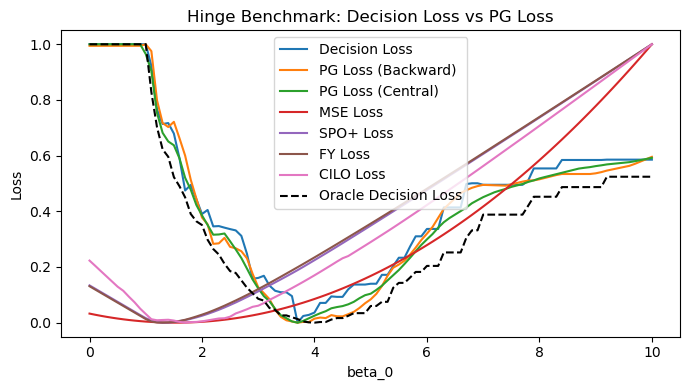

In [8]:
#rescale and shift losses for better visualization to be between 0 and 1
def scale_to_unit_interval(x):
      x = np.asarray(x)
      xmin = np.min(x)
      xmax = np.max(x)
      if xmax == xmin:
          return np.zeros_like(x, dtype=float)
      return (x - xmin) / (xmax - xmin)


decision_losses = scale_to_unit_interval(decision_losses)
pgb_losses = scale_to_unit_interval(pgb_losses)
pgc_losses = scale_to_unit_interval(pgc_losses)
mse_losses = scale_to_unit_interval(mse_losses)
spoplus_losses = scale_to_unit_interval(spoplus_losses)
fy_losses = scale_to_unit_interval(fy_losses)
smooth_pgb_losses = scale_to_unit_interval(smooth_pgb_losses)
smooth_pgc_losses = scale_to_unit_interval(smooth_pgc_losses)
smooth_spoplus_losses = scale_to_unit_interval(smooth_spoplus_losses)
smooth_fy_losses = scale_to_unit_interval(smooth_fy_losses)
cilo_losses = scale_to_unit_interval(cilo_losses)
decision_loss_oracle = scale_to_unit_interval(decision_loss_oracle)


#compute the minimizer for each loss
betastar_dl = betas[np.argmin(decision_losses)]
betastar_pgb = betas[np.argmin(pgb_losses)]
betastar_pgc = betas[np.argmin(pgc_losses)]
betastar_mse = betas[np.argmin(mse_losses)]
betastar_spoplus = betas[np.argmin(spoplus_losses)]
betastar_fy = betas[np.argmin(fy_losses)]   
betastar_cilo = betas[np.argmin(cilo_losses)]
betastar_oracle = betas[np.argmin(decision_loss_oracle)]

betastar_smooth_pgb = betas[np.argmin(smooth_pgb_losses)]
betastar_smooth_pgc = betas[np.argmin(smooth_pgc_losses)]
betastar_smooth_spoplus = betas[np.argmin(smooth_spoplus_losses)]
betastar_smooth_fy = betas[np.argmin(smooth_fy_losses)]   

#print them out
print(f"Minimizer for Decision Loss: {betastar_dl:.4f}")
print(f"Minimizer for PG Loss (Backward): {betastar_pgb:.4f}")
print(f"Minimizer for PG Loss (Central): {betastar_pgc:.4f}")
print(f"Minimizer for SPO+ Loss: {betastar_spoplus:.4f}")
print(f"Minimizer for FY Loss: {betastar_fy:.4f}")
print(f"Minimizer for MSE Loss: {betastar_mse:.4f}")
print(f"Minimizer for CILO Loss: {betastar_cilo:.4f}")
print(f"Minimizer for Oracle Decision Loss: {betastar_oracle:.4f}")

# print(f"Minimizer for Smooth PG Loss (Backward): {betastar_smooth_pgb:.4f}")
# print(f"Minimizer for Smooth PG Loss (Central): {betastar_smooth_pgc:.4f}")
# print(f"Minimizer for Smooth SPO+ Loss: {betastar_smooth_spoplus:.4f}")
# print(f"Minimizer for Smooth FY Loss: {betastar_smooth_fy:.4f}")


plt.figure(figsize=(7, 4))
plt.plot(betas, decision_losses, label="Decision Loss ")
plt.plot(betas, pgb_losses, label="PG Loss (Backward)")
plt.plot(betas, pgc_losses, label="PG Loss (Central)")
plt.plot(betas, mse_losses, label="MSE Loss")
plt.plot(betas, spoplus_losses, label="SPO+ Loss")
plt.plot(betas, fy_losses, label="FY Loss")
plt.plot(betas, cilo_losses, label="CILO Loss")
plt.plot(betas, decision_loss_oracle, label="Oracle Decision Loss", linestyle="dashed", color="black")
# plt.plot(betas, smooth_pgb_losses, label="Smooth PG Loss (Backward)")
# plt.plot(betas, smooth_pgc_losses, label="Smooth PG Loss (Central)")
# plt.plot(betas, smooth_spoplus_losses, label="Smooth SPO+ Loss")
# plt.plot(betas, smooth_fy_losses, label="Smooth FY Loss")
plt.xlabel("beta_0")
plt.ylabel("Loss")
plt.title("Hinge Benchmark: Decision Loss vs PG Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [86]:
#Create a pandas dataframe with a column for beta, and then each of the losses, and then save it to a csv
import pandas as pd
df = pd.DataFrame({
    "beta": betas,
    "decision_loss": decision_losses,
    "oracle_decision_loss": decision_loss_oracle,
    "pgb_loss": pgb_losses,
    "pgc_loss": pgc_losses,
    "mse_loss": mse_losses,
    "spoplus_loss": spoplus_losses,
    "fy_loss": fy_losses,
    "cilo_loss": cilo_losses,
    "smooth_pgb_loss": smooth_pgb_losses,
    "smooth_pgc_loss": smooth_pgc_losses,
    "smooth_spoplus_loss": smooth_spoplus_losses,
    "smooth_fy_loss": smooth_fy_losses,
})
df.to_csv("hinge_loss_landscape.csv", index=False)